# Introduction

This notebook presents an analysis of an HR dataset using machine learning techniques to predict employee promotions. The notebook covers various stages of the data science pipeline, including data preprocessing, feature engineering, data visualization, model training, fairness metrics assessment, and bias mitigation techniques.

## Understanding AI Ethics, Its Problems, and Solutions

Ethical considerations in AI are crucial due to the potential impact of AI systems on individuals and society. AI ethics involves ensuring that AI systems are designed, deployed, and utilized in a fair, transparent, and accountable manner. However, issues such as bias, lack of transparency, data privacy concerns, unclear accountability, and unintended consequences pose significant challenges in AI ethics.

Addressing these issues involves employing fairness and bias mitigation techniques, developing explainable AI systems, implementing robust data privacy and security measures, establishing clear ethical guidelines and regulatory frameworks, promoting diverse and inclusive development teams, and continuously monitoring and evaluating AI systems for ethical concerns.

By integrating ethical considerations and addressing potential biases, this notebook aims to demonstrate the importance of aligning AI technologies with ethical principles and societal values.

## 1. Data Preprocessing

In [1]:
%%capture

!pip install holisticai
!pip install cvxpy

In [2]:
# Import the necessary libraires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from holisticai.efficacy.metrics import classification_efficacy_metrics
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.mitigation import Reweighing, DisparateImpactRemover, EqualizedOdds
from holisticai.bias.plots import (group_pie_plot, frequency_plot,
                                   disparate_impact_plot, disparate_impact_curve)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Set the max columns that can be shown
pd.set_option("display.max_columns", 100)

(CVXPY) Jan 13 05:19:52 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Jan 13 05:19:52 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


In [3]:
# Import the data
df = pd.read_csv('../input/hranalysis/train.csv')

# Create a copy of the dataframe
data = df.copy()

# Display the first few rows
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
# Checking the shape of the dataframe
df.shape

(54808, 14)

In [5]:
# Print informations about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [6]:
# Display descriptive statistics
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [7]:
# Checking if there are missing values
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
# Filling the missing values with the mode
df['education'].fillna(df['education'].mode()[0], inplace=True)

# Filling the missing values with the mean
df['previous_year_rating'].fillna(df['previous_year_rating'].mean(), inplace=True)

# Printing the number of missing values
print(f"The number of missing values: {df.isna().sum().sum()}")

The number of missing values: 0


In [9]:
# Removing 'region_' and leaving only the number of the regions
df['region'] = df['region'].apply(lambda x: re.sub('[^0-9.]', '', str(x)))

# Converting the region column to integer type
df['region'] = df['region'].astype('int')

In [10]:
# Drop the 'employee_id' column since it's not relevant for our analysis
df.drop(['employee_id'], axis=1, inplace=True)

In [11]:
# Converting the gender column into binary values
df['gender'] = df['gender'].map({'f': 0,
                                 'm': 1})

# Converting the education column into numerical values
df['education'] = df['education'].map({'Below Secondary': 0,
                                       "Bachelor's": 1,
                                       "Master's & above": 2})

In [12]:
# Convert 'recruitment_channel' column into dummy variables, and drop the original column
df_dummies1 = pd.get_dummies(df['recruitment_channel'], prefix='recruitment_channel')
df = pd.concat([df, df_dummies1], axis=1)
df.drop('recruitment_channel', axis=1, inplace=True)

# Convert 'department' column into dummy variables, and drop the original column
df_dummies = pd.get_dummies(df['department'], prefix='department')
df = pd.concat([df, df_dummies], axis=1)
df.drop('department', axis=1, inplace=True)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

## 2. Feature Engineering

In [13]:
# Combine 'KPIs_met >80%' and 'awards_won?' to create an indicator for high performers who also received awards
df['high_performer'] = df['KPIs_met >80%'] & df['awards_won?']

# Display the first 5 rows
df[['KPIs_met >80%', 'awards_won?', 'high_performer']].head()

,KPIs_met >80%,awards_won?,high_performer
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [14]:
# Create a unique identifier for each combination
df['gender_training_interaction'] = pd.factorize(df['gender'].astype(str) + '_' + df['no_of_trainings'].astype(str))[0]

# Convert the identifier to a integer
df['gender_training_interaction'] = df['gender_training_interaction'].astype(int)

# Display the first 5 rows
df[['gender', 'no_of_trainings', 'gender_training_interaction']].head()

,gender,no_of_trainings,gender_training_interaction
0,0,1,0
1,1,1,1
2,1,1,1
3,1,2,2
4,1,1,1


The calculation for the `gender_training_interaction` column is done through two steps:

1. Concatenation: The `gender` and `no_of_trainings` values are converted to strings and concatenated with an underscore between them. This creates a new categorical string that represents the unique combinations of `gender` and `no_of_trainings`.

2. Factorization: The concatenated strings are then passed through the `pd.factorize()` function, which assigns a unique integer to each unique string. The first unique string encountered is assigned an integer code of 0, the second unique string is assigned a code of 1, and this continues for all unique combinations.

Here's a breakdown of the calculation for the first few rows:

- For the first row (index 0), `gender` is `0` and `no_of_trainings` is `1`. The concatenated string is "0_1". Since this is the first unique string, it is assigned the code `0`.
- For the second row (index 1), `gender` is `1` and `no_of_trainings` is `1`. The concatenated string is "1_1". This is a new unique string, so it is assigned the code `1`.
- The third row (index 2) has the same combination as the second row, so it receives the same code `1`.
- The fourth row (index 3) introduces a new combination, "1_2", which is assigned the next available code `2`.

This process is repeated for all rows. When a new combination appears, such as "0_2" at index 41, it is assigned a new code `3`. When "1_3" appears at index 43, it is assigned code `4`. The `factorize` function keeps track of all unique strings and ensures that each one is assigned a distinct integer.

This approach allows the model to treat each unique combination of `gender` and `no_of_trainings` as a distinct category, which can be important if the effect of training varies by gender.

## 3. Exploratory Data Analysis

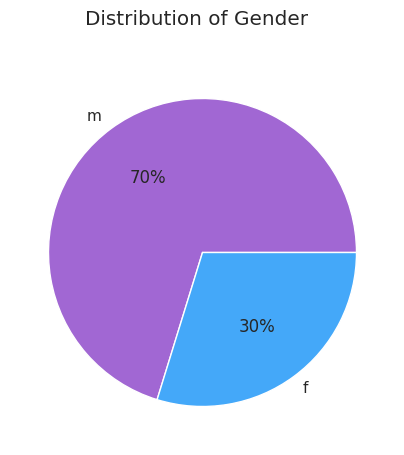

In [15]:
# Visualizing gender distribution with a pie plot
group_pie_plot(data['gender'], title="Distribution of Gender", size=(5, 5))

# Display the plot
plt.show()

*The dataset exhibits a significant imbalance in gender representation, with a disproportionately high number of male individuals. This suggests a potential bias in the data collection process or a lack of diversity in the sample population.*

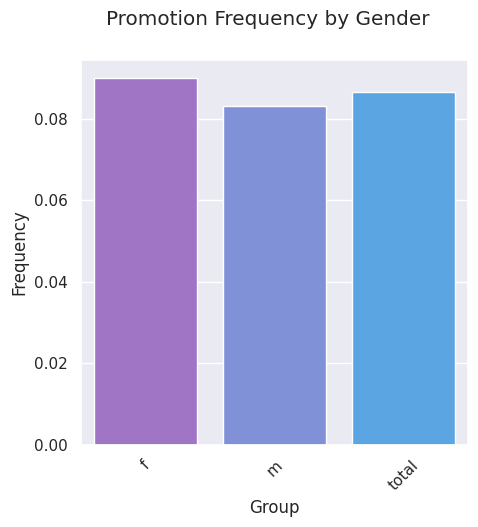

In [16]:
# Visualizing the frequency of promotions based on gender
frequency_plot(data['gender'], data['is_promoted'], title="Promotion Frequency by Gender", size=(5, 5))

# Display the plot
plt.show()

*The data also reveals a notable disparity in career advancement between genders, with females exhibiting a significantly higher rate of promotion compared to males. This suggests that females within the dataset have had more opportunities for professional growth and advancement than their male counterparts.*

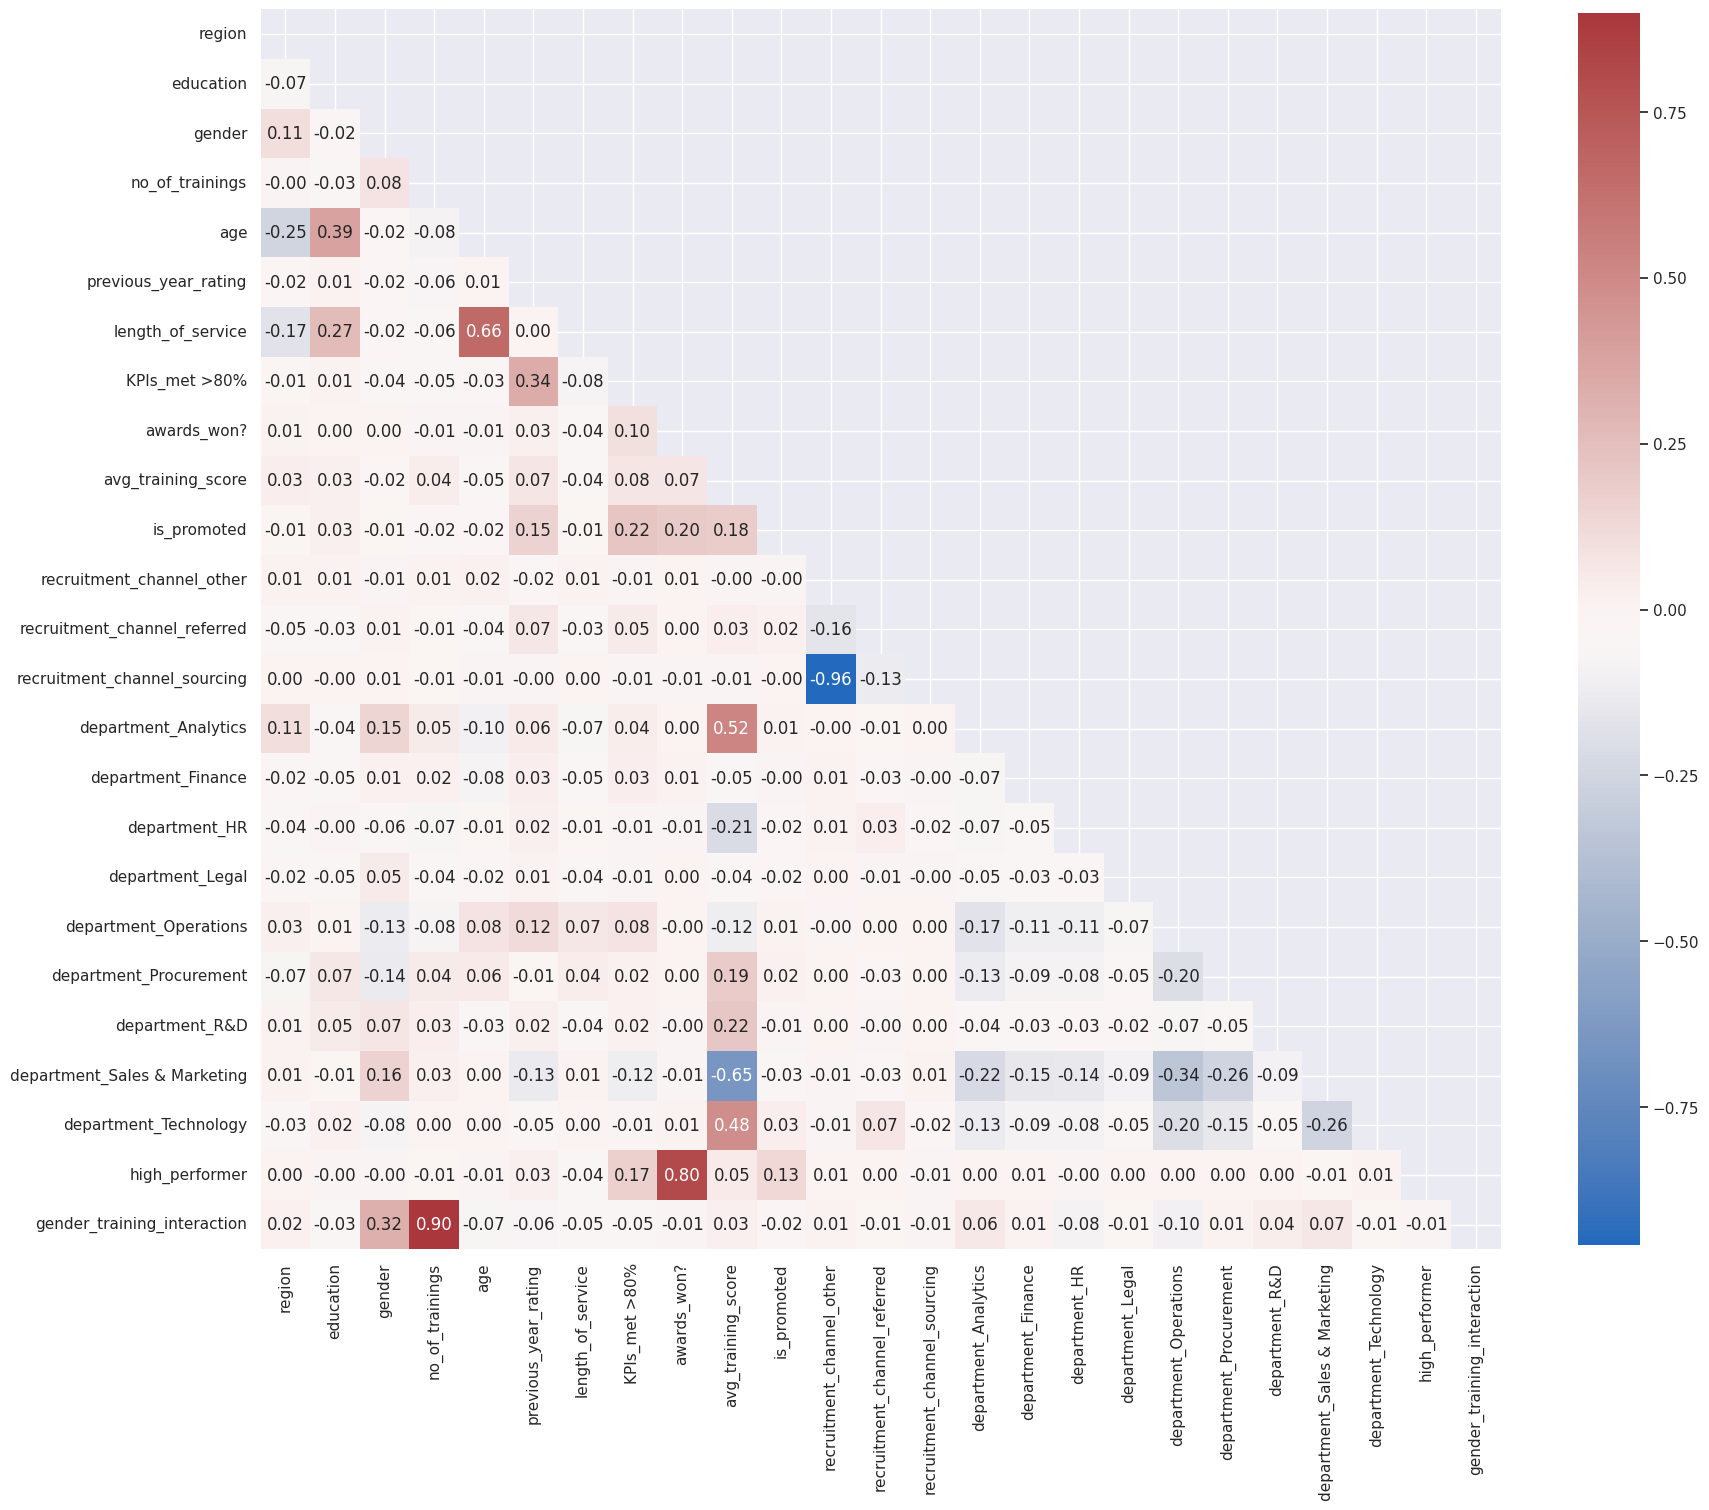

In [17]:
# Visualizing correlation matrix with a heatmap using Seaborn
cor = df.corr(numeric_only=True)

# Create a triangular mask for the upper part of the heatmap
mask = np.triu(np.ones_like(cor, dtype=bool))

# Set up the plot with a specified figure size
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a heatmap with annotated correlation values
sns.heatmap(cor, annot=True, fmt=".2f",
            cmap="vlag",square=True,
            cbar_kws={"shrink": 0.8},
            mask=mask, ax=ax)

# Display the plot
plt.show()

## 4. Data Splitting

In [18]:
# Splitting the dataset into training and testing sets
X = df.drop(["is_promoted"], axis=1)
y = df["is_promoted"]

# Perform train-test split with 70% for training and 30% for testing, maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

## 5. Model Training

In [19]:
# Initialize Logistic Regression model with specified parameters
model = LogisticRegression(solver="liblinear",
                           fit_intercept=True,
                           random_state=42)

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Obtaining predicted probabilities for each class on the test data
y_proba = model.predict_proba(X_test)

In [20]:
# Evaluate classification efficacy metrics for the unmitigated model
classification_efficacy_metrics(y_pred, y_test, y_proba)

,Value,Reference
Metric,,
Accuracy,0.931643,1
Balanced Accuracy,0.910128,1
Precision,0.225714,1
Recall,0.887640,1
F1-Score,0.359909,1
AUC,0.910128,1
Log Loss,2.463849,0


*Although I can enhance the model's accuracy by applying methods like GridSearch, parameter tuning, and data scaling, I've chosen not to do so for the purpose of this notebook. We're primarily interested in examining the data for biases, and optimizing the model further will reduce the disparate impact, potentially obscuring any underlying bias.*

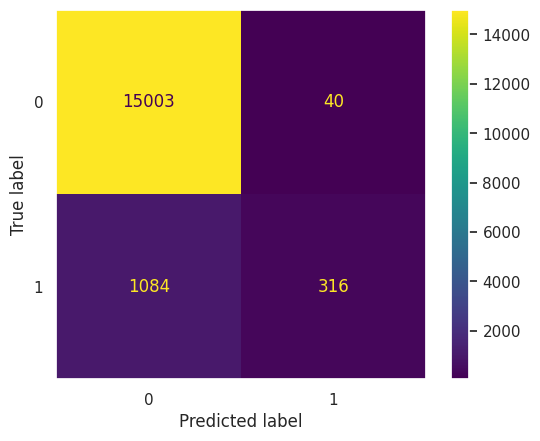

In [21]:
# Calculate confusion matrix from test labels and predictions
cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

- **True Negatives:** 15003 employees were correctly predicted as not promoted.
- **False Positives:** 40 employees were incorrectly predicted as promoted.
- **False Negatives:** 1084 employees were incorrectly predicted as not promoted.
- **True Positives:** 316 employees were correctly predicted as promoted.

**Key Points:**

- The model is highly accurate for predicting non-promotions.
- It is less adept at identifying actual promotions, as indicated by a high number of false negatives.
- The precision is fairly good, but the recall is low, suggesting a need to improve the model's sensitivity to promoting cases.
- The low recall indicates that many actual promotions are being missed.

## 6. Fairness Metrics and Mitigation
### 6.1 Unmitigated Model Metrics

In [22]:
# Creating boolean masks to separate data into two groups based on gender for train set
group_a = X_train["gender"] == 0
group_b = X_train["gender"] == 1

# Creating boolean masks to separate data into two groups based on gender for test set
group_a_t = X_test["gender"] == 0
group_b_t = X_test["gender"] == 1

In [23]:
# Computing classification bias metrics for the unmitigated model with a focus on the 'female' group
unmitigated_metrics = classification_bias_metrics(group_a=group_a_t,
                                                  group_b=group_b_t,
                                                  y_pred=y_pred,
                                                  y_true=y_test,
                                                  metric_type='both')

# Displaying the unmitigated metrics
unmitigated_metrics.round(4)

,Value,Reference
Metric,,
Statistical Parity,0.0082,0
Disparate Impact,1.4248,1
Four Fifths Rule,0.7019,1
Cohen D,0.0563,0
2SD Rule,3.2739,0
Equality of Opportunity Difference,0.0458,0
False Positive Rate Difference,0.0008,0
Average Odds Difference,0.0233,0
Accuracy Difference,-0.0080,0


- **Statistical Parity:** The value of 0.0082, being above 0, suggests bias against group_b (males), although the effect is relatively minor as it's within the acceptable range (-0.1, 0.1).
- **Disparate Impact:** The value of 1.4248, being above 1, indicates bias against group_b (males), as the positive outcome is more likely for females (group_a).
- **Four Fifths Rule:** The value of 0.7019 is below the acceptable range (0.8, 1), indicating bias against group_b (males).
- **Cohen's D:** The small positive value of 0.0563 shows a slight bias against group_b (males), but the effect size is negligible.
- **2SD Rule:** The high value of 3.2739 is beyond the desirable value of 0, indicating a statistically significant difference in success rates and therefore bias against group_b (males).
- **Equality of Opportunity Difference:** The positive value of 0.0458 shows a minor bias against group_b (males).
- **False Positive Rate Difference:** The minute positive value of 0.0008 shows an almost negligible bias against group_b (males).
- **Average Odds Difference:** The positive value of 0.0233 shows bias against group_b (males), though the effect is minor as it's within the acceptable range (-0.1, 0.1).
- **Accuracy Difference:** The negative value of -0.0080, indicates a slight bias against group_a (females).

These results suggest that while the biases are generally minor, there are some significant disparities (e.g., disparate impact, four-fifths rule, 2SD rule) that indicate this ML model is unfair towards males (group_b).

### 6.2 Reweighing

In [24]:
# Load mitigator (Reweighing)
reweighing = Reweighing()

# Use mitigator in data
reweighing.fit(y_train,
                         group_a,
                         group_b)

# Access the new sample_weight
sw = reweighing.estimator_params["sample_weight"]

# Training the model
model.fit(X_train,
          y_train,
          sample_weight=sw)

# Make predictions
y_pred = model.predict(X_test)

# Create a table with bias metrics for mitigation strategy
reweighing_metrics = classification_bias_metrics(group_a=group_a_t,
                                                 group_b=group_b_t,
                                                 y_pred=y_pred,
                                                 y_true=y_test,
                                                 metric_type='both')

# Displaying the computed bias metrics
reweighing_metrics.round(4)

,Value,Reference
Metric,,
Statistical Parity,0.0075,0
Disparate Impact,1.3860,1
Four Fifths Rule,0.7215,1
Cohen D,0.0515,0
2SD Rule,2.9964,0
Equality of Opportunity Difference,0.0425,0
False Positive Rate Difference,0.0004,0
Average Odds Difference,0.0214,0
Accuracy Difference,-0.0078,0


*After applying reweighting mitigation, minor improvements in fairness metrics are observed. However, biases against group_b (males) still persist, particularly in Disparate Impact, Four Fifths Rule, and 2SD Rule metrics.*

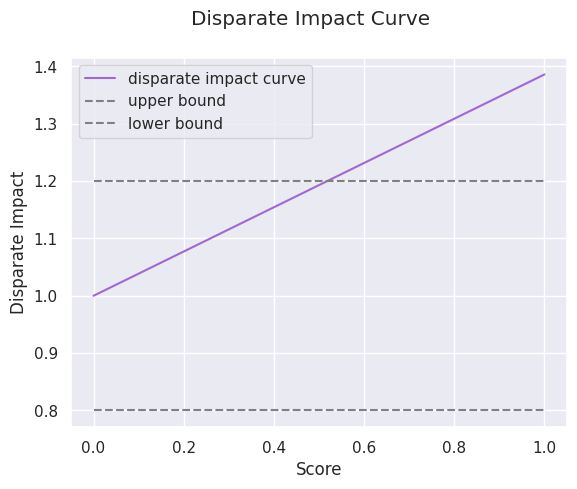

In [25]:
# Display the Disparate Impact versus threshold curve
disparate_impact_curve(group_a_t, group_b_t, y_pred, x_axis='score')

# Show the plot
plt.show()

*The plot indicates that the disparate impact curve surpasses the upper threshold, suggesting the presence of disparate impact.*

### 6.3 Equalized Odds

In [26]:
# Training the model on the original training data
model.fit(X_train, y_train)

# Making predictions on the test data
y_pred = model.predict(X_test)

# Configuring test parameters for the Equalized Odds mitigator
fit_params = {"group_a": group_a_t, "group_b": group_b_t}

# Load mitigator (EqualizedOdds)
post = EqualizedOdds(solver='highs', seed=42)

# Training the model with the configured parameters
post.fit(y_test, y_pred, **fit_params)

# Configuring training parameters for the Equalized Odds mitigator
#fit_params = {"group_a": group_a, "group_b": group_b}

# Configuring the parameters for transforming predictions
transform_params = {"group_a": group_a_t, "group_b": group_b_t}

# Making predictions on the test data
y_pred = model.predict(X_test)

# Transforming predictions using the Equalized Odds post-processing
y_pred = post.transform(y_pred, **transform_params)["y_pred"]

# Calculating classification bias metrics for the model with Equalized Odds post-processing
equalizedodds_metrics = classification_bias_metrics(group_a=group_a_t,
                                                       group_b=group_b_t,
                                                       y_pred=y_pred,
                                                       y_true=y_test,
                                                       metric_type='both')
# Displaying the computed bias metrics
equalizedodds_metrics.round(4)

,Value,Reference
Metric,,
Statistical Parity,0.0032,0
Disparate Impact,1.1643,1
Four Fifths Rule,0.8589,1
Cohen D,0.0226,0
2SD Rule,1.3160,0
Equality of Opportunity Difference,-0.0003,0
False Positive Rate Difference,0.0002,0
Average Odds Difference,-0.0001,0
Accuracy Difference,-0.0118,0


*After applying the Equalized Odds mitigation technique, there's a significant improvement in fairness metrics. Bias against group_b (males) has notably decreased, with most metrics nearing the acceptable range. Disparate Impact and Four Fifths Rule are closer to 1, and the 2SD Rule is now below 2.*

### 6.4 Disparate Impact Remover

In [27]:
# Load mitigator (DisparateImpactRemover)
preprocessing_mitigator = DisparateImpactRemover(repair_level=1.0)

# Fitting the mitigator and tronsforming the training data for both groups
fit_params = {"group_a": group_a, "group_b": group_b}
X_train_s = preprocessing_mitigator.fit_transform(X_train, **fit_params)

# Training the model
model.fit(X_train_s, y_train)

# Transforming the test data using the same mitigator configuration
fit_params = {"group_a": group_a_t, "group_b": group_b_t}
X_test_s = preprocessing_mitigator.transform(X_test, **fit_params)

# Making predictions on the mitigated test data
y_pred = model.predict(X_test)

# Create a table with bias metrics for mitigation strategy
disparateimpactremover_metrics = classification_bias_metrics(group_a=group_a_t,
                                                       group_b=group_b_t,
                                                       y_pred=y_pred,
                                                       y_true=y_test,
                                                       metric_type='both')

# Displaying the computed bias metrics
disparateimpactremover_metrics.round(4)

,Value,Reference
Metric,,
Statistical Parity,-0.0003,0
Disparate Impact,0.9897,1
Four Fifths Rule,0.9897,1
Cohen D,-0.0018,0
2SD Rule,-0.1071,0
Equality of Opportunity Difference,0.0147,0
False Positive Rate Difference,-0.0060,0
Average Odds Difference,0.0044,0
Accuracy Difference,-0.0038,0


*Using the Disparate Impact Remover mitigation, the model appears to be mostly fair as all metrics are within or very close to the acceptable range. This suggests that biases have been substantially reduced for both groups.*

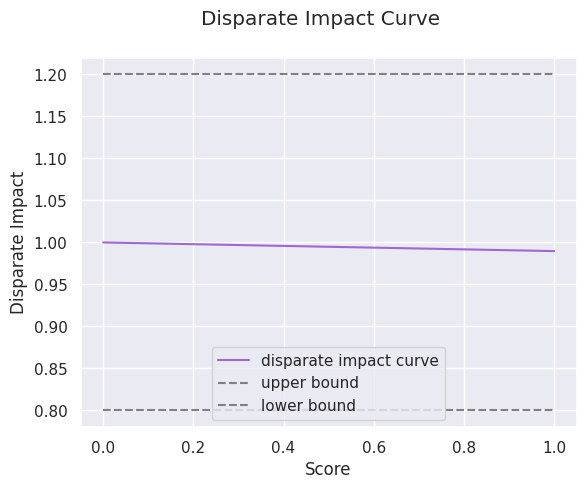

In [28]:
# Display the Disparate Impact versus threshold curve
disparate_impact_curve(group_a_t, group_b_t, y_pred, x_axis='score')

# Show the plot
plt.show()

*The disparate impact curve is positioned between the two thresholds, indicating a fair model.*

# Conclusion

In this notebook, we explored the fairness of a machine learning model for promotion prediction. We started by analyzing the raw data, identifying gender as a potential source of bias. We then calculated various fairness metrics to quantify the extent of bias in the unmitigated model.

To address the observed biases, we applied three different mitigation techniques: Reweighing, Equalized Odds, and Disparate Impact Remover. We evaluated the effectiveness of each mitigation strategy by examining the resulting fairness metrics.

The results showed that Equalized Odds and Disparate Impact Remover were effective in reducing bias, while Reweighing had a more limited impact. We also observed that the disparate impact curve for the Equalized Odds and Disparate Impact Remover models fell within the acceptable range, indicating that these models were fair.

While we have made progress in improving the fairness of the model, it is important to note that there may still be residual biases that are not captured by the metrics we used. It is also worth considering additional factors that may contribute to bias, such as the selection of features and the choice of model architecture.

## Future Work

In future work, we can explore more advanced mitigation techniques, such as adversarial debiasing and counterfactual fairness. We can also consider incorporating additional fairness constraints into the model training process. By continuously monitoring and mitigating bias, we can strive to create machine learning models that are fair and just.